In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from grouper import group_by_volume, group_by_time
from pyfolio.timeseries import perf_stats
from functools import partial
from utils import chart_price, plot, perf, v_backtester, c_backtester, perf_var
import sys
from functools import partial
sys.path.append('/home/tomek/ib_tools')
from indicators import get_ATR, get_signals
from candlesticks import candlesticks
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
time_int = 30
periods = 100
multi_periods = [5, 10, 20, 40, 80, 160] 
roc_periods = [5, 10]
vol_lookback = 200
smooth = int(np.ceil(periods/4))
atr_periods = 80

In [3]:
contract = pd.read_pickle('data/minute_NQ_cont_non_active_included.pickle')
contract = contract.loc['20180101': '20181231']
#contract = contract.loc['20190401':]
#contract = contract.loc['20180202': '20180630']
#contract = contract.loc['20190101': '20190410']

In [4]:
vols = pd.DataFrame({'close': contract.close,})
vols['returns'] = vols['close'].pct_change()
vols['vol_returns'] = vols['returns'].ewm(span=vol_lookback, min_periods=int(vol_lookback*.9)).std()
vols['vol_price'] = vols['vol_returns'] * vols['close']
vols['vol_price_alt'] = vols['close'].ewm(span=vol_lookback, min_periods=int(vol_lookback*.9)).std()

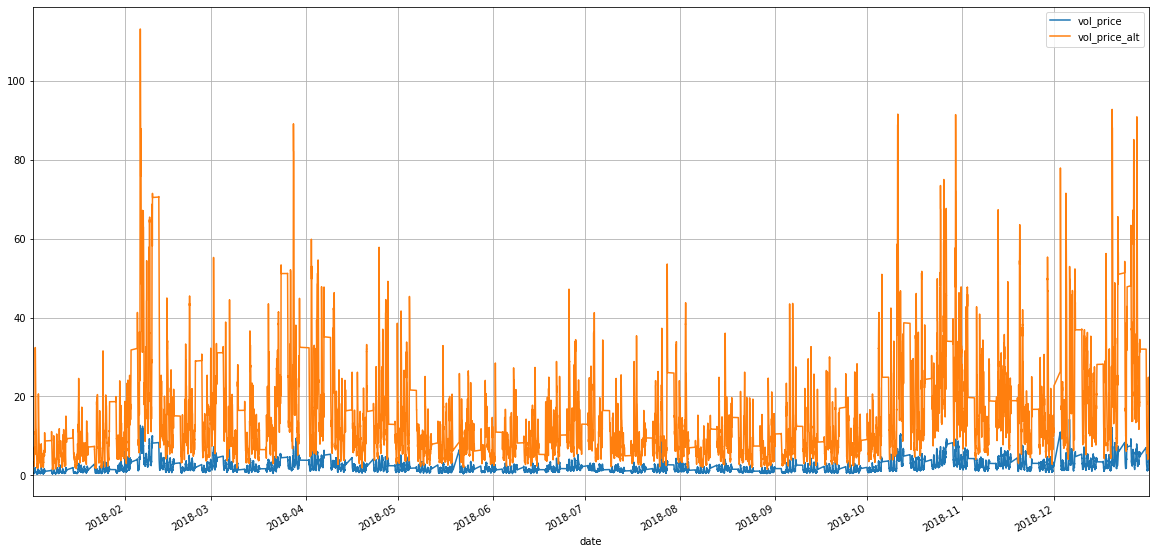

In [5]:
vols[['vol_price', 'vol_price_alt']].plot(figsize=(20,10), grid=True);

In [6]:
#avg_vol = contract.loc['20190621':].volume.rolling(time_int).sum().mean()
avg_vol = contract.volume.rolling(time_int).sum().mean()
avg_vol

9984.567471188768

In [7]:
vol_candles = group_by_volume(contract, avg_vol)
vol_candles['atr'] = get_ATR(vol_candles, atr_periods)
vol_candles

,date,open,high,low,close,barCount,volume,atr
label,,,,,,,,
0,2018-01-02 06:04:00,6405.00,6423.75,6401.50,6419.25,5279,9946,22.250000
1,2018-01-02 12:01:00,6419.25,6423.25,6397.75,6409.25,6475,10010,23.895313
2,2018-01-02 14:27:00,6409.25,6437.75,6408.75,6434.75,5153,9966,25.639589
3,2018-01-02 15:29:00,6435.25,6443.50,6431.00,6440.25,4387,9681,22.230495
4,2018-01-02 15:34:00,6440.50,6445.00,6426.25,6430.00,5953,13846,21.499161
...,...,...,...,...,...,...,...,...
10915,2018-12-31 21:55:00,6322.25,6324.50,6302.00,6317.00,5265,9751,27.322754
10916,2018-12-31 21:58:00,6316.75,6317.00,6294.75,6304.50,3380,6599,27.197501
10917,2018-12-31 22:00:00,6304.50,6353.00,6303.75,6344.00,6841,13661,27.742007


In [8]:
data = pd.DataFrame({'date': vol_candles.date,
                     'open': vol_candles.open,
                     'close': vol_candles.close})

In [9]:
def carver(data, periods, smooth, *args):
    data = data.copy()
    data['max'] = data.close.rolling(periods).max()
    data['min'] = data.close.rolling(periods).min()
    data['mid'] = data[['min', 'max']].mean(axis=1)
    data['breakout'] = data['close'] - data['mid']
    data['breakout_norm'] = data['breakout'] / (data['max'] - data['min'])
    data[f'carver_{periods}'] = data['breakout_norm'].ewm(span=smooth).mean()
    return data[f'carver_{periods}']

In [10]:
def ema(data, periods, smooth, vol):
    data = data.copy()
    data['ema_fast'] = data.close.ewm(span=periods).mean()
    data['ema_slow'] = data.close.ewm(span=periods*3).mean()
    data['ema_diff'] = data.ema_fast - data.ema_slow
    data['ema_diff_norm'] = data.ema_diff / vol
    #data['ema_diff_norm'] = data.ema_diff / data.ema_diff.rolling(periods).std()
    data[f'ema_{periods}'] = data['ema_diff_norm'].ewm(span=smooth).mean()
    return data[f'ema_{periods}']

In [11]:
def breakout(data, periods, smooth, *args):
    data['max'] = (data.close >= data.close.rolling(periods).max()) * 1
    data['min'] = (data.close <= data.close.rolling(periods).min()) * 1
    data[f'breakout_{periods}'] = (data['max'] - data['min']).ewm(span=smooth).mean()
    return data[f'breakout_{periods}']

In [12]:
def diff(data, periods, smooth, vol):
    data = data.copy()
    data['diff'] = data.close.pct_change(periods) * 100
    data['diff_norm'] = data['diff'] / vol
    data[f'diff_{periods}'] = data['diff_norm'].ewm(span=smooth).mean()
    return data[f'diff_{periods}']

In [13]:
def vol(data, vol_lookback):
    data = data.copy()
    data['returns'] = data['close'].pct_change()
    data['vol_returns'] = data['returns'].ewm(span=vol_lookback, min_periods=int(vol_lookback*.9)).std()
    data['vol_price'] = data['vol_returns'] * data['close']
    return data['vol_price']

In [14]:
vols = vol(data, vol_lookback)

In [15]:
def combine(data, multi_periods, smooth, vol, funcs):
    result = pd.DataFrame()
    for func in funcs:
        result[func.__name__] = pd.DataFrame([func(data, p, smooth, vol) for p in multi_periods]).T.mean(axis=1)
    return result

In [16]:
forecasts = combine(data, multi_periods, smooth, vols, [carver, ema, breakout])
forecasts['diff'] = pd.DataFrame([diff(data, p, smooth, vols) for p in roc_periods]).T.mean(axis=1)

In [17]:
forecasts.tail()

,carver,ema,breakout,diff
label,,,,
10915,0.045811,0.398961,0.032489,-0.002184
10916,0.023893,0.388528,0.004349,-0.003794
10917,0.046774,0.386665,0.029656,-0.002682
10918,0.070353,0.392426,0.065836,-0.000410
10919,0.092067,0.403628,0.099233,0.001418


In [18]:
data = data.join(forecasts)
data = data.iloc[200:]

In [19]:
#plot(data[['close', 'carver', 'ema', 'diff']])

In [20]:
10 / data[['carver', 'ema', 'diff', 'breakout']].abs().mean()

carver       55.247183
ema           4.526932
diff        624.467439
breakout     66.594719
dtype: float64

In [21]:
scaled = pd.DataFrame({'date': data.date,
                       'open': data.open,
                       'close': data.close,
                       'carver': (data.carver * 20).clip(lower=-20, upper=20),
                       'breakout': (data.breakout * 80).clip(lower=-20, upper=20),
                       'ema': (data.ema * 3.5).clip(lower=-20, upper=20),
                       'diff': (data['diff'] * 624).clip(lower=-20, upper=20)
                      }
                     )

In [22]:
scaled['combined'] = scaled[['ema',  'breakout',]].mean(axis=1)

In [23]:
scaled['combined'].std()

8.986677368139333

In [24]:
10 / scaled['combined'].std() 

1.1127583188257344

In [25]:
scaled['combined'] = scaled['combined'] * 1.1

In [26]:
scaled[['carver', 'ema', 'diff', 'breakout']].corr()

,carver,ema,diff,breakout
carver,1.000000,0.567015,0.839208,0.923466
ema,0.567015,1.000000,0.263959,0.417968
diff,0.839208,0.263959,1.000000,0.917304
breakout,0.923466,0.417968,0.917304,1.000000


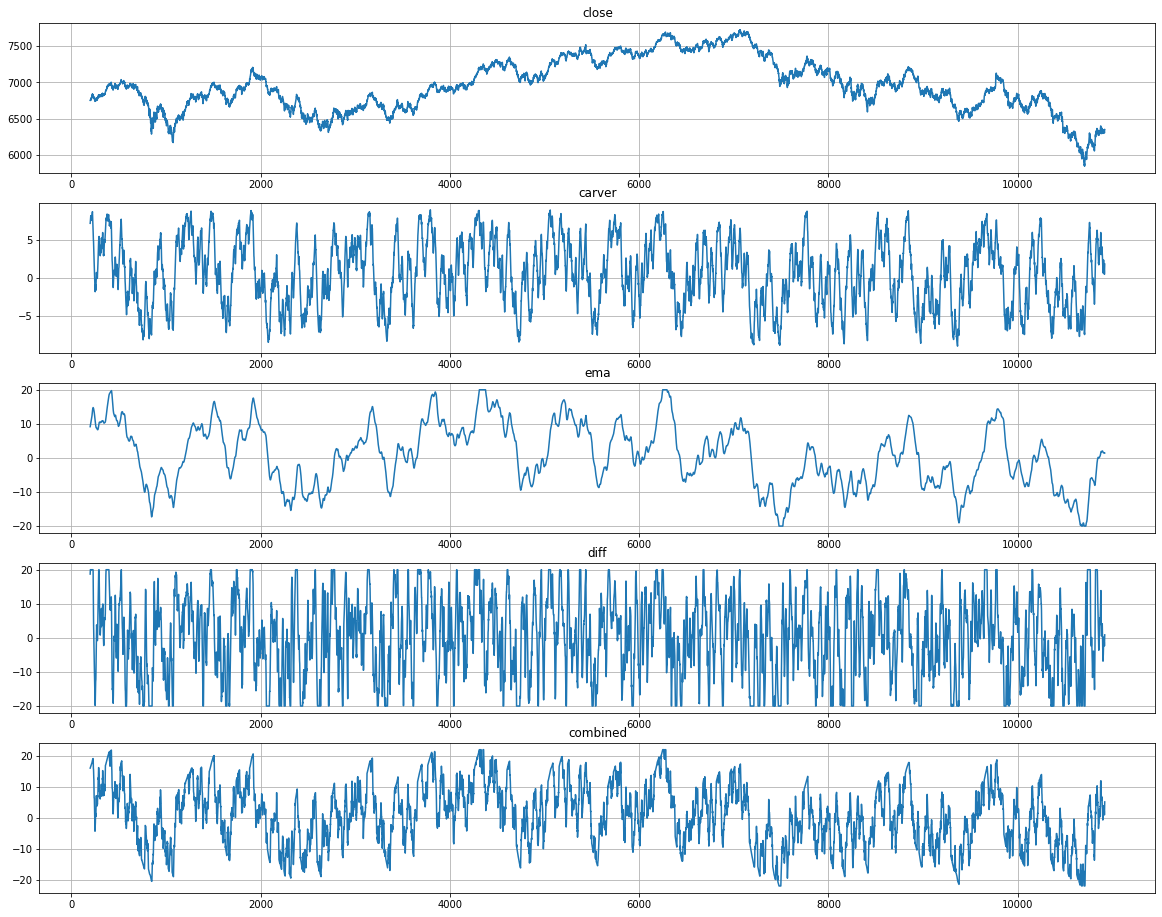

In [27]:
plot(scaled[['close', 'carver', 'ema', 'diff', 'combined']])

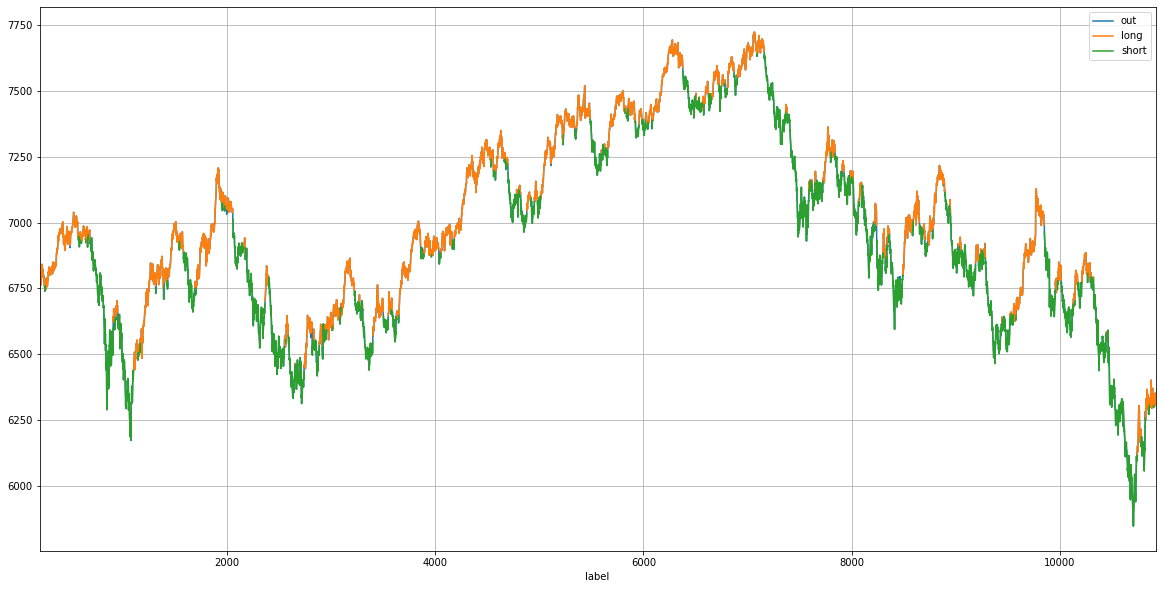

In [28]:
scaled_reindexed = scaled.set_index('date')
chart_price(scaled.close, scaled['combined'], 0);

In [29]:
stats = pd.DataFrame()
dailys = pd.DataFrame()
returns = pd.DataFrame()
for i in [0, 1, 2, 3, 4, 5, 6, 7, 10, ]: #12, 15, 20]:
    b = v_backtester(scaled_reindexed.open, scaled_reindexed.combined, i)
    r = perf_var(b, False)
    stats[i] = r.stats
    dailys[i] = r.daily.balance
    returns[i] = r.daily['returns']

In [30]:
stats

,0,1,2,3,4,5,6,7,10
Annual return,0.126821,0.109428,0.05249,0.122436,0.0869493,0.0800209,0.00516101,-0.0197971,0.050684
Cumulative returns,0.127355,0.109886,0.0527037,0.122951,0.0873089,0.0803509,0.00518154,-0.0198749,0.0508901
Annual volatility,0.200361,0.193151,0.196442,0.18886,0.185548,0.176645,0.167345,0.157684,0.117286
Sharpe ratio,0.695688,0.633594,0.357934,0.705461,0.54138,0.523436,0.113764,-0.0486306,0.479672
Calmar ratio,1.12509,1.03321,0.447475,1.53264,1.25211,1.15688,0.0660433,-0.217231,0.606436
Stability,0.574218,0.37848,0.0479202,0.327403,0.31984,0.362976,0.130788,0.00837098,0.270944
Max drawdown,-0.112721,-0.105911,-0.117303,-0.0798858,-0.069442,-0.0691694,-0.0781458,-0.091134,-0.0835768
Omega ratio,1.12557,1.1124,1.0614,1.12673,1.0958,1.0936,1.01972,0.991572,1.0976
Sortino ratio,1.04669,0.978452,0.547026,1.10001,0.861275,0.834041,0.177209,-0.0758694,0.794193
Skew,0.165613,0.419355,0.438341,0.38419,0.60614,0.591841,0.601136,0.728571,1.12699


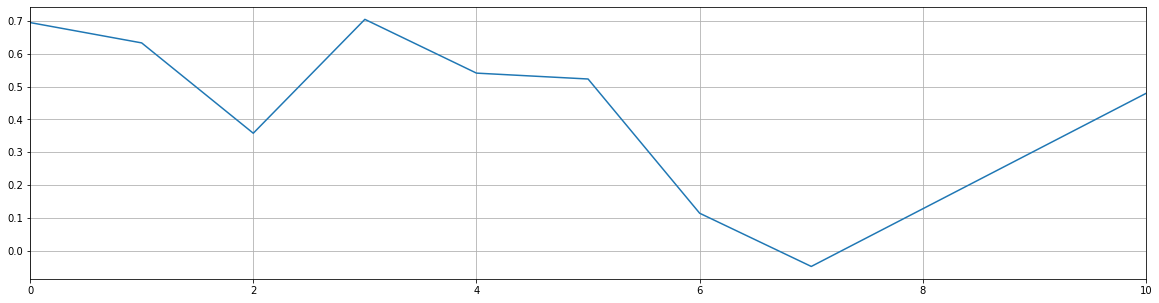

In [31]:
stats.loc['Sharpe ratio',].plot(figsize=(20,5), grid=True);

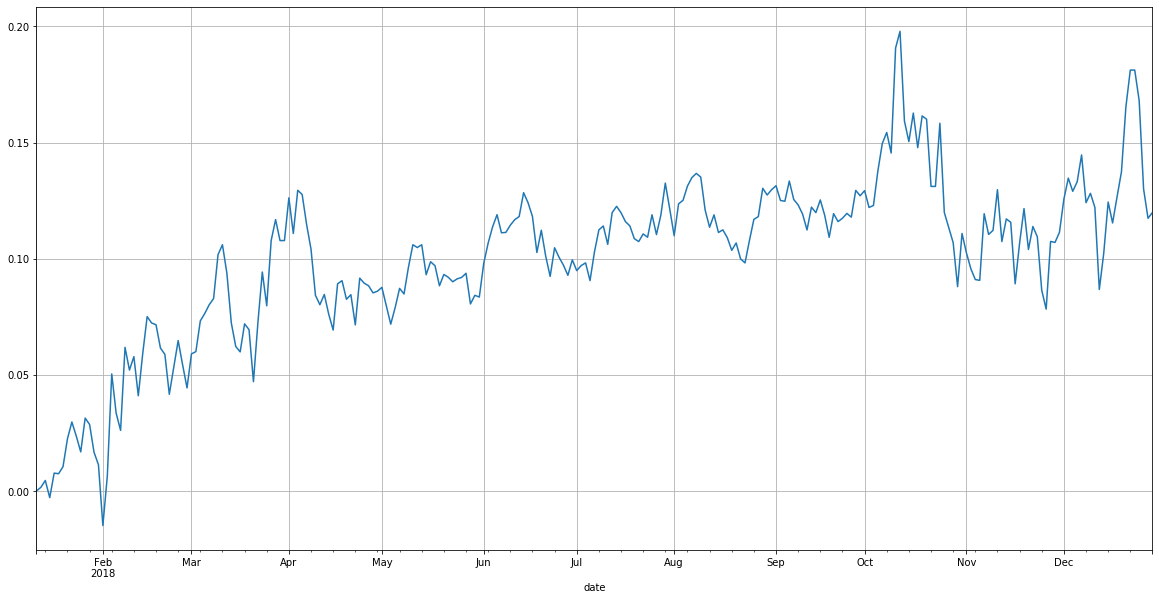

In [32]:
np.log(returns[0]+1).cumsum().plot(figsize=(20, 10), grid=True);

In [33]:
stats = pd.DataFrame()
dailys = pd.DataFrame()
returns = pd.DataFrame()
for i in [0, 5, 10, 15]:
    b = v_backtester(scaled_reindexed.open, scaled_reindexed.combined, i)
    r = perf(b, multiplier, bankroll, False)
    stats[i] = r.stats
    dailys[i] = r.daily.balance
    returns[i] = r.daily['returns']

In [34]:
stats

,0,5,10,15
Annual return,1.14053,0.719961,0.45616,0.251552
Cumulative returns,1.147,0.723667,0.458333,0.252667
Annual volatility,1.11185,1.23204,0.741953,0.64827
Sharpe ratio,1.22046,1.02729,0.861397,0.657903
Calmar ratio,2.73824,1.81386,1.15455,0.716131
Stability,0.554508,0.360544,0.288554,0.102629
Max drawdown,-0.416517,-0.396922,-0.395096,-0.351265
Omega ratio,1.24131,1.19197,1.18772,1.20399
Sortino ratio,2.04143,1.789,1.5297,1.12837
Skew,0.913642,1.00526,1.50243,1.71316
